In [129]:
#https://www.kaggle.com/pschale/mlb-pitch-data-20152018

import pandas as pd
import numpy as np
import os.path
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#if not os.path.exists('Scherzer.csv'):
if True:
    #setting up dataset 'scherzer' to have desired features
    pitches = pd.read_csv('pitches.csv')
    pitches = pitches.drop(pitches.columns[:26], axis=1)
    pitches = pitches.drop('event_num', axis=1)
    pitches = pitches.drop('type', axis=1)

    #Only selecting pitches from Max Scherzer
    scherzer_id = 453286
    at_bats = pd.read_csv('atbats.csv')
    at_bats = at_bats.drop(['o', 'event', 'p_throws'], axis=1)
    just_scherzer = at_bats.loc[at_bats['pitcher_id'] == scherzer_id]

    scherzer = pitches.merge(just_scherzer, how='inner', on=['ab_id'])


    #Removing intentional walks and Two-Seam Fastballs
    scherzer = scherzer[scherzer.code != 'I']
    scherzer = scherzer[scherzer.pitch_type != 'FT']
    scherzer = scherzer[scherzer.pitch_type != 'UN']

    #reads in games csv, which gives home team, start_time, and weather features
    games = pd.read_csv('games.csv')
    games = games.drop(['attendance', 'away_final_score', 'away_team', 'date', 'elapsed_time', 'home_final_score', 'umpire_1B',
           'umpire_2B', 'umpire_3B', 'umpire_HP', 'venue_name','delay'], axis=1)

    scherzer = scherzer.merge(games, how='inner', on=['g_id'])

    scherzer = scherzer.reset_index(drop=True)

    print(scherzer.shape)
    

(13434, 23)


In [130]:
#Converting the code column to bionary, a '1' if the batter reached base without an out and '0' otherwise
def convert_code_column(dataframe):
    if np.issubdtype(dataframe['code'].dtype, np.number):
        return dataframe
    else:
        dataframe = dataframe.reset_index(drop=True)
        target_col = []
        for i in range(len(dataframe['code'])):
            pitch = dataframe['code'][i]
            num_balls = int(dataframe['b_count'][i])

            if (pitch == 'B' or pitch == '*B') and num_balls == 3:
                target_col.append(1)

            elif pitch == 'D' or pitch == 'E' or pitch == 'H':
                target_col.append(1)

            else:
                target_col.append(0)

        dataframe['code'] = target_col
        return dataframe


#function that vectorizes a column of classes
def featurize(dataframe, column_name):
    if not column_name in dataframe.columns:
        return dataframe
    class_dct = {}
    count = 0
    dataframe = dataframe.reset_index(drop=True)
    for instance in dataframe[column_name]:
        count += 1
        header = column_name + '_' + str(instance)
        if not header in class_dct.keys():
            class_dct[header] = np.zeros(count - 1)
        
        for key in class_dct.keys():
            if key == header:
                class_dct[key] = np.append(class_dct[key], 1)
            else:
                class_dct[key] = np.append(class_dct[key], 0)
                
    dataframe = dataframe.drop([column_name], axis=1)
    
    for key in class_dct.keys():
        dataframe[key] = class_dct[key]
        
    return dataframe

#function designed to combine the zone and pitch-type features
def Combine_Features(dataframe, zone, pitch_type):
    if not 'zone' in dataframe.columns or not 'pitch_type' in dataframe.columns:
        return dataframe
    else:
        class_dct = {}
        for i in range(dataframe['zone'].size):
            this_zone = str(dataframe['zone'][i])
            this_pitch = str(dataframe['pitch_type'][i])

            header = 'zone_' + this_zone + '_pitch_' + this_pitch
            if not header in class_dct.keys():
                class_dct[header] = np.zeros(i)

            for key in class_dct.keys():
                if key == header:
                    class_dct[key] = np.append(class_dct[key], 1)
                else:
                    class_dct[key] = np.append(class_dct[key], 0)

        dataframe = dataframe.drop([zone, pitch_type], axis=1)

        for key in class_dct.keys():
            dataframe[key] = class_dct[key]

        return dataframe

#function that creates two new features, 'pitch_height' and 'pitch_width' which gives the coordinates of the pitch
def create_coordinates(dataframe):
    if 'pitch_height' in dataframe.columns:
        return dataframe
    else:
        heights = []
        widths = []
        width_dct = {1.0:-1,2.0:0,3.0:1,4.0:-1,5.0:0,6.0:1,7.0:-1,8.0:0,9.0:1,11.0:-2,12.0:2,13.0:-2,14.0:2}
        height_dct = {1.0:1,2.0:1,3.0:1,4.0:0,5.0:0,6.0:0,7.0:-1,8.0:-1,9.0:-1,11.0:2,12.0:2,13.0:-2,14.0:-2}
        
        for i in range(len(dataframe['zone'])):
            zone = dataframe['zone'][i]
            stand =  dataframe['stand'][i]
            if stand == 'L':
                if zone in width_dct.keys():
                    widths.append(width_dct[zone])
                    heights.append(height_dct[zone])
                else:
                    widths.append(0)
                    heights.append(0)
            else:
                if zone in width_dct.keys():
                    widths.append(-width_dct[zone])
                    heights.append(height_dct[zone])
                else:
                    widths.append(0)
                    heights.append(0)

        dataframe['pitch_height'] = heights
        dataframe['pitch_width'] = widths
        return dataframe

#Creates an extra 10 features where each feature is a pitch type and either height or width.  This feature will
#be either 0 if the instance is a different pitch type or its corresponding height or width if the instance is the
#same pitch type
def creat_zone_coordinates(dataframe):
    if 'FF_height' in dataframe.columns:
        return dataframe
    
    dataframe = dataframe.reset_index(drop=True)
    all_pitches = {'FF_height':[], 'FF_width': [], 'CH_height': [], 'CH_width': [], 'SL_height': [], 'SL_width': [], 'FC_height': [], 'FC_width': [], 'CU_height': [], 'CU_width': []}
    for i in range(dataframe['pitch_type'].size):
        pitch_type = dataframe['pitch_type'][i]
        for key in all_pitches.keys():
            p_type = key[:2]
            coord = key[-6:]
            if p_type == pitch_type:
                if coord == 'height':
                    all_pitches[key].append(dataframe['pitch_height'][i])
                else:
                    all_pitches[key].append(dataframe['pitch_width'][i])
            else:
                all_pitches[key].append(0)
                
    for ky in all_pitches.keys():
        dataframe[ky] = all_pitches[ky]
    
    return dataframe

#creates a new feature 'run_dif' which is the score differnce between pitchers team and batters team and
#'run_total'
def run_dif(dataframe):
    if 'run_dif' in dataframe:
        return dataframe
    dataframe['run_dif'] = dataframe['b_score'] - dataframe['p_score']
    dataframe['run_total'] = dataframe['b_score'] + dataframe['p_score']
    dataframe = dataframe.drop(['b_score', 'p_score'], axis=1)
    return dataframe

#makes "home_team" feature numerical by changing home games to 1 and away games to zero
def home_team(dataframe):
    first_entry = dataframe['home_team'][0]
    if first_entry ==0 or first_entry == 1:
        return dataframe
    
    home_games = []
    for game in dataframe['home_team']:
        if game == 'was':
            home_games.append(1)
        else:
            home_games.append(0)
    dataframe['home_team'] = home_games
    return dataframe

#function that takes in a time like "4:05 pm" and converts it to a number on a scale from 1 to 25
def convert_time(string):
    output = 0
    try:  
        tim, day = string.split(' ')
        hour, minute = tim.split(':')
        hour = int(hour)
        minute = int(minute)/60
        if day == 'pm':
            hour += 12
            
        output = hour+minute
    except:
        pass
    
    return output

#function that converts start_time column        
def start_time(dataframe):
    first_entry = dataframe['start_time'][0]
    if isinstance(first_entry, float):
        return dataframe

    new_times = []
    for tim in dataframe['start_time']:
        new_times.append(convert_time(tim))

    dataframe['start_time'] = new_times

    return dataframe

#function that takes in a time like "4:05 pm" and converts it to a number on a scale from 1 to 25
def convert_weather(string):
    output = 70
    try:  
        output = int(string.split(' ')[0])
    except:
        pass
    
    return output

#function that converts start_time column        
def weather(dataframe):
    first_entry = dataframe['weather'][0]
    if not isinstance(first_entry, str):
        return dataframe

    new_temps = []
    for temp in dataframe['weather']:
        new_temps.append(convert_weather(temp))

    dataframe['weather'] = new_temps

    return dataframe
  

In [131]:
#if not os.path.exists('Scherzer.csv'):
if True:
    scherzer = convert_code_column(scherzer)
    scherzer = create_coordinates(scherzer)
    scherzer = creat_zone_coordinates(scherzer)
    scherzer = run_dif(scherzer)
    scherzer = home_team(scherzer)
    scherzer = start_time(scherzer)
    scherzer = weather(scherzer)
    
    scherzer.to_csv(path_or_buf='Scherzer_beta.csv')

In [132]:
#given the id of the batter, the zone of the pitch, and the type of pitch this function will give the
#batter a score based on their historical performance with that pitch.  If the batter has faced less than
#100 such pitches, the function returns Max Scherzer's score for that pitch
scherzer_beta = pd.read_csv('Scherzer_beta.csv')

player_dct = {}
def look_up_hitter(batter_id, zone, pitch):
    if batter_id in player_dct.keys():
        this_batter = player_dct[batter_id]
    else:
        just_this_batter = at_bats.loc[at_bats['batter_id'] == batter_id]
        this_batter = pitches.merge(just_this_batter, how='inner', on=['ab_id'])

        #this_batter = combine_zones(this_batter)
        player_dct[batter_id] = this_batter

    this_batter = this_batter.loc[this_batter['zone'] == zone]
    this_batter = this_batter.loc[this_batter['pitch_type'] == pitch]

    if this_batter.shape[0] < 100:
        maxs_av = scherzer_beta.loc[scherzer_beta['zone'] == zone]
        maxs_av = maxs_av.loc[maxs_av['pitch_type'] == pitch]
        if maxs_av.code.sum() == 0 or maxs_av.code.size == 0:
            return 0
        else:
            return maxs_av.code.sum()/maxs_av.code.size

    else:
        this_batter = this_batter[this_batter.code != 'I']
        this_batter = this_batter.reset_index(drop=True)
        this_batter = convert_code_column(this_batter)

        if this_batter.code.sum() == 0 or this_batter.code.size == 0:
            return 0
        else:
            return this_batter.code.sum()/this_batter.code.size

look_up_hitter(451594,5,'FF')

0.15263157894736842

In [133]:
#Adds the feature 'batter_score' to dataframe, calculated by the look_up_hitter_function
#player_dct keeps track of the dataframe for each hitter so that it does not to be recalculated for each new pitch

def batter_scores(dataframe):
    if 'batter_score' in dataframe.columns:
        return dataframe
    
    dataframe = dataframe.reset_index(drop=True)
    batter_scores = []
    for i in range(dataframe['batter_id'].size):
        if i%100 == 0:
            print(i)
        batter_id = dataframe['batter_id'][i]
        zone = dataframe['zone'][i]
        pitch = dataframe['pitch_type'][i]
        score = look_up_hitter(batter_id, zone, pitch)
        batter_scores.append(score)
    
    dataframe['batter_score'] = batter_scores
    return dataframe

#if not os.path.exists('Scherzer.csv'):
if True:
    scherzer = batter_scores(scherzer)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400


In [134]:
#if not os.path.exists('Scherzer.csv'):
if True:
    scherzer.to_csv(path_or_buf='Scherzer.csv')

In [135]:
scherzer = pd.read_csv('Scherzer.csv')
scherzer_beta = pd.read_csv('Scherzer_beta.csv')

In [136]:
print('The fraction of pitches resulting the runner reaching:',scherzer.code.sum()/scherzer.code.size)

The fraction of pitches resulting the runner reaching: 0.06297454220634212


In [137]:
avg_batter = np.mean(scherzer['batter_score'])

In [138]:
all_pitches = []
for pitch in scherzer['pitch_type']:
    if not pitch in all_pitches:
        all_pitches.append(pitch)
        
all_pitches[-1] = 'unknown'
all_pitches

['FF', 'CH', 'SL', 'FC', 'CU', 'unknown']

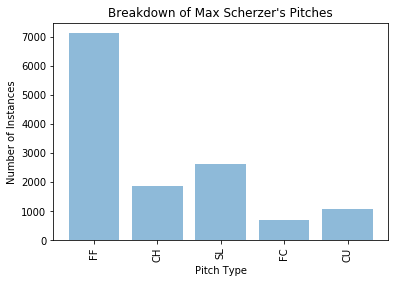

In [139]:
all_pitches = []
frequencies = []
for pitch in scherzer['pitch_type']:
    if not pitch in all_pitches:
        all_pitches.append(pitch)

all_pitches = all_pitches[:-1]
for pitch in all_pitches:
    frequencies.append(scherzer.loc[scherzer['pitch_type'] == pitch].shape[0])

y_pos = np.arange(len(all_pitches))

plt.bar(y_pos, frequencies, align='center', alpha=0.5)
plt.xticks(y_pos, all_pitches)
plt.xlabel('Pitch Type')
plt.ylabel('Number of Instances')
plt.title("Breakdown of Max Scherzer's Pitches")
plt.xticks(rotation=90)
 
plt.show()

In [140]:
frequencies[0]/np.sum(frequencies)

0.5315160567587752

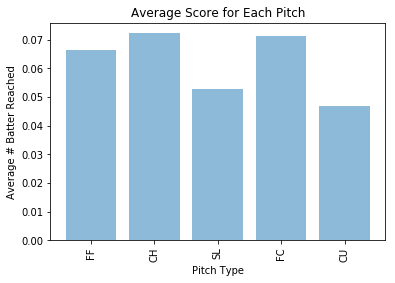

In [141]:
effectiveness = []
for pitch in all_pitches:
    pitch_df = scherzer.loc[scherzer['pitch_type'] == pitch]
    effectiveness.append(np.sum(pitch_df['code'])/pitch_df.shape[0])

y_pos = np.arange(len(all_pitches))

plt.bar(y_pos, effectiveness, align='center', alpha=0.5)
plt.xticks(y_pos, all_pitches)
plt.ylabel('Average # Batter Reached')
plt.xlabel('Pitch Type')
plt.title('Average Score for Each Pitch')
plt.xticks(rotation=90)
 
plt.show()

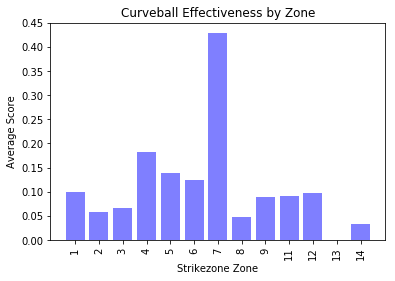

In [142]:
cutters = []
cutters2 = []
zones = [1,2,3,4,5,6,7,8,9,11,12,13,14]
for zone in zones:
    pitch_df = scherzer.loc[scherzer['zone'] == zone]
    pitch_df = pitch_df.loc[pitch_df['pitch_type'] == 'FC']
    cutters.append(np.sum(pitch_df['code'])/pitch_df.shape[0])
    cutters2.append(pitch_df.shape[0])

y_pos = np.arange(len(zones))

plt.bar(y_pos, cutters, align='center', alpha=0.5, color='blue')
#plt.bar(y_pos, cutters2, align='center', alpha=0.5, color = 'orange')
plt.xticks(y_pos, zones)
plt.xlabel('Strikezone Zone')
plt.ylabel('Average Score')
plt.title('Curveball Effectiveness by Zone')
plt.xticks(rotation=90)
 
plt.show()

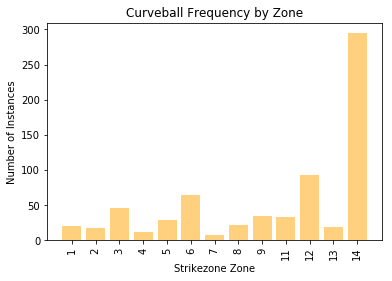

In [143]:
plt.bar(y_pos, cutters2, align='center', alpha=0.5, color = 'orange')
plt.xticks(y_pos, zones)
plt.xlabel('Strikezone Zone')
plt.ylabel('Number of Instances')
plt.title('Curveball Frequency by Zone')
plt.xticks(rotation=90)
 
plt.show()

In [144]:
to_be_vectorized = ['pitch_type','p_throws', 'stand']
to_be_dropped = ['Unnamed: 0','zone', 'ab_id', 'g_id', 'pitcher_id', 'top', 'wind', 'pitch_height', 'pitch_width']
ready_to_go = ['code', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'inning', 'home_team',
              'start_time', 'weather']

scherzer.columns

Index(['Unnamed: 0', 'zone', 'code', 'pitch_type', 'ab_id', 'b_count',
       's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'batter_id',
       'g_id', 'inning', 'pitcher_id', 'stand', 'top', 'home_team',
       'start_time', 'weather', 'wind', 'pitch_height', 'pitch_width',
       'FF_height', 'FF_width', 'CH_height', 'CH_width', 'SL_height',
       'SL_width', 'FC_height', 'FC_width', 'CU_height', 'CU_width', 'run_dif',
       'run_total', 'batter_score'],
      dtype='object')

In [145]:
for col_name in to_be_vectorized:
    scherzer = featurize(scherzer, col_name)
    
scherzer = scherzer.drop(to_be_dropped, axis=1)

In [146]:
y = scherzer['code']
X = scherzer.drop(['code'], axis=1)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()


X_train = x_train.drop(['batter_id'], axis=1)
X_test = x_test.drop(['batter_id'], axis=1)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

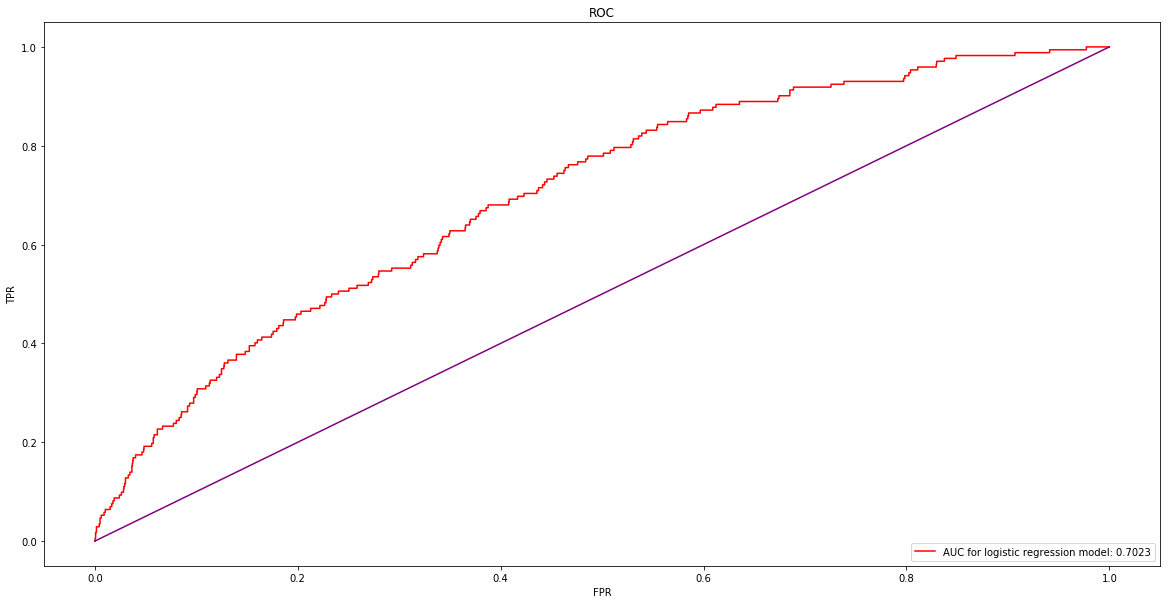

In [147]:
#creates logisitic regression model
model_1 = sklearn.linear_model.LogisticRegression(C=1e5)
logistic_model  = model_1.fit(X_train, y_train)

#creates respective result vectors
y_score_logistic = logistic_model.predict_proba(X_test)[:,1]

#calculates logistic fpr, tpr, and auc values
fpr_logistic, tpr_logistic, thresholds_logistic = metrics.roc_curve(y_test, y_score_logistic, drop_intermediate=False)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)


#graph
plt.figure(figsize=(20,10))

plt.plot(fpr_logistic, tpr_logistic, color = 'red', label= 'AUC for logistic regression model: ' + str(round(roc_auc_logistic, 4)))
#plt.plot(fpr_svm, tpr_svm, color = 'blue', label = 'AUC for SVM model: ' + str(round(roc_auc_svm, 4)))
plt.plot(fpr_logistic, fpr_logistic, color='purple')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


In [150]:
print(x_test.columns)
    

def pitch_zone(height, width, stand):
    if stand == 'R':
        if height< 0 and width < 0:
            return 'Low, Inside', 9
        elif height> 0 and width > 0:
            return 'High, Outside', 1
        elif height< 0 and width > 0:
            return 'Low, Outside', 7
        elif height> 0 and width < 0:
            return 'High, Inside', 3
        elif height == 0 and width < 0:
            return 'Inside', 6
        elif height == 0 and width > 0:
            return 'Outside', 4
        elif height> 0 and width == 0:
            return 'High', 2
        elif height< 0 and width == 0:
            return 'Low', 8
        elif height== 0 and width == 0:
            return 'Down the Middle', 5
    else:
        if height< 0 and width < 0:
            return 'Low, Outside', 9
        elif height> 0 and width > 0:
            return 'High, Inside', 1
        elif height< 0 and width > 0:
            return 'Low, Inside', 7
        elif height> 0 and width < 0:
            return 'High, Outside', 3
        elif height == 0 and width < 0:
            return 'Outside', 6
        elif height == 0 and width > 0:
            return 'Inside', 4
        elif height> 0 and width == 0:
            return 'High', 2
        elif height< 0 and width == 0:
            return 'Low', 8
        elif height== 0 and width == 0:
            return 'Down the Middle', 5
    

def reset_instance(instance):
    for trait in ['FF_height', 'FF_width',
       'CH_height', 'CH_width', 'SL_height', 'SL_width', 'FC_height',
       'FC_width', 'CU_height', 'CU_width', 'pitch_type_FF', 'pitch_type_CH', 'pitch_type_SL',
       'pitch_type_FC', 'pitch_type_CU', 'pitch_type_nan']:
        instance[trait] = 0
        
        
    return None



def predict_pitch(instance):
    pitch_dct = {}
    if instance['stand_R'] == 1:
        stand = 'R'
    else:
        stand = 'L'
    for pitch in all_pitches:
        for height in [-2,-1,0,1,2]:
            for width in [-2,-1,0,1,2]:
                copy = instance
                reset_instance(copy)
                copy[pitch + '_height'] = height
                copy[pitch + '_width'] = width
                copy['pitch_type_' + pitch] = 1
                
                copy['batter_score'] = look_up_hitter(copy['batter_id'], pitch_zone(height,width,stand)[1], pitch)
                #copy['batter_score'] = avg_batter
                copy  = copy.drop(['batter_id'])
                copy = np.array(copy).reshape(1, -1)
                copy = scaler.transform(copy)
                prob = logistic_model.predict_proba(copy)[0][1]
                pitch_dct[prob] = [pitch, height, width]
                
    pit,het, wid = pitch_dct[min(pitch_dct.keys())]
    return pit, pitch_zone(het, wid, stand)[0]
                
                

for i in range(10):
    print(predict_pitch(x_test.iloc[i]), x_test.iloc[i]['stand_R'])

Index(['b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b',
       'batter_id', 'inning', 'home_team', 'start_time', 'weather',
       'FF_height', 'FF_width', 'CH_height', 'CH_width', 'SL_height',
       'SL_width', 'FC_height', 'FC_width', 'CU_height', 'CU_width', 'run_dif',
       'run_total', 'batter_score', 'pitch_type_FF', 'pitch_type_CH',
       'pitch_type_SL', 'pitch_type_FC', 'pitch_type_CU', 'pitch_type_nan',
       'stand_L', 'stand_R'],
      dtype='object')


/Users/ajaklevs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ajaklevs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ajaklevs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ajaklevs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is tr

('CU', 'High, Outside') 1.0
('CU', 'High, Inside') 0.0
('CU', 'High, Outside') 1.0
('CU', 'High, Outside') 1.0
('CU', 'High, Inside') 0.0
('CU', 'High, Inside') 0.0
('FF', 'High, Inside') 1.0
('CU', 'High, Inside') 0.0
('FF', 'High, Inside') 1.0
('CU', 'High, Inside') 0.0


In [151]:
for i in range(10):
    print(predict_pitch(x_test.iloc[i+10]), x_test.iloc[i+10]['stand_R'])

/Users/ajaklevs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ajaklevs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ajaklevs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ajaklevs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is tr

('CU', 'High, Inside') 0.0
('CU', 'High, Outside') 1.0
('CU', 'High, Inside') 0.0
('CU', 'High, Inside') 0.0
('CU', 'High, Inside') 0.0
('CU', 'High, Inside') 0.0
('CU', 'High, Outside') 1.0
('CU', 'High, Outside') 1.0
('CU', 'High, Inside') 0.0
('CU', 'High, Inside') 0.0
